In [2]:
import numpy as np
from PIL import Image
from torchvision import transforms

# 이미지 전처리 함수
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_image(img_path):
    image = Image.open(img_path).convert("RGB")
    return transform(image).unsqueeze(0)  # (1, 3, 224, 224)


In [21]:
! pip install seaborn

   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
   ---- ----------------------------------- 1.3/11.6 MB 8.4 MB/s eta 0:00:02
   ---------- ----------------------------- 3.1/11.6 MB 7.4 MB/s eta 0:00:02
   ---------------- ----------------------- 4.7/11.6 MB 7.7 MB/s eta 0:00:01
   ----------------------- ---------------- 6.8/11.6 MB 7.9 MB/s eta 0:00:01
   ---------------------------- ----------- 8.1/11.6 MB 7.7 MB/s eta 0:00:01
   ---------------------------------- ----- 10.0/11.6 MB 7.9 MB/s eta 0:00:01
   -------------------------------------- - 11.3/11.6 MB 7.7 MB/s eta 0:00:01
   ---------------------------------------- 11.6/11.6 MB 7.6 MB/s eta 0:00:00


c:\Users\LG\elice\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


[ 1.11157224e-02 -5.07276803e-02  3.20638746e-01 -6.95332419e-03
 -2.12472081e-02  9.75774229e-02  1.89812794e-01 -8.70838910e-02
  1.71269849e-03 -1.73150480e-01 -2.26985857e-01  7.59487599e-02
  1.12215690e-02  1.56397760e-01  3.53644788e-01  2.61594445e-01
 -2.99091898e-02 -1.30882055e-01  6.86164424e-02  2.34767318e-01
  1.16213098e-01 -1.69165015e-01 -2.15783000e-01  9.20624584e-02
 -6.35668784e-02 -1.71293870e-01 -2.67829716e-01 -1.56507656e-01
  3.03649455e-02 -2.51497895e-01 -2.83668220e-01 -1.22497380e-01
 -4.45249025e-03  2.34119594e-03  2.67126501e-01  1.33236900e-01
 -1.57205075e-01  2.86134720e-01  7.46959522e-02 -2.73401618e-01
  1.94984943e-01 -8.60041305e-02 -1.91478148e-01 -4.49392736e-01
  1.16505533e-01 -3.56119238e-02  1.19251713e-01 -3.46456841e-02
  1.31676704e-01 -1.82554871e-01  2.35264480e-01  5.71621470e-02
  8.89238864e-02 -2.55985558e-01  1.83022730e-02 -1.38537824e-01
  1.90983266e-01  2.69707106e-03  4.77942489e-02 -1.42096505e-01
  1.19969606e-01  1.78893

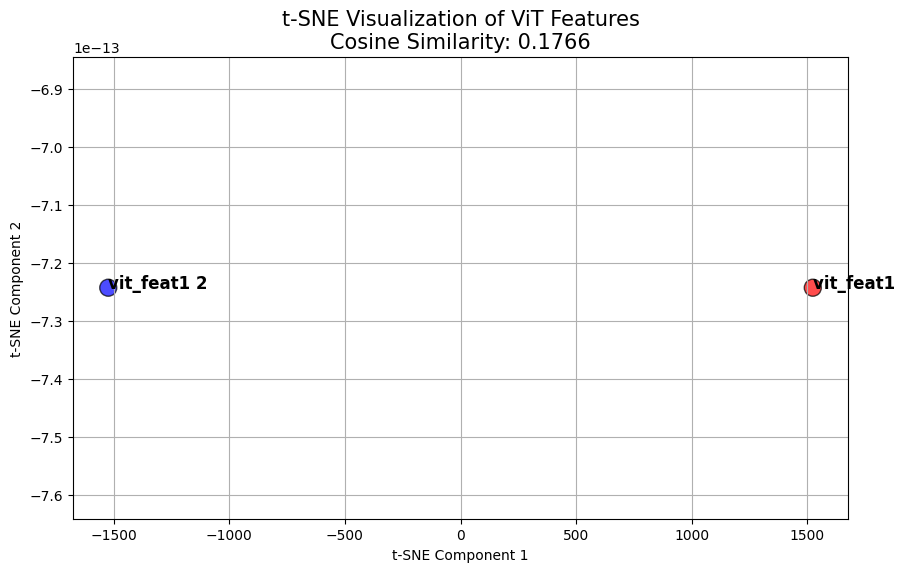

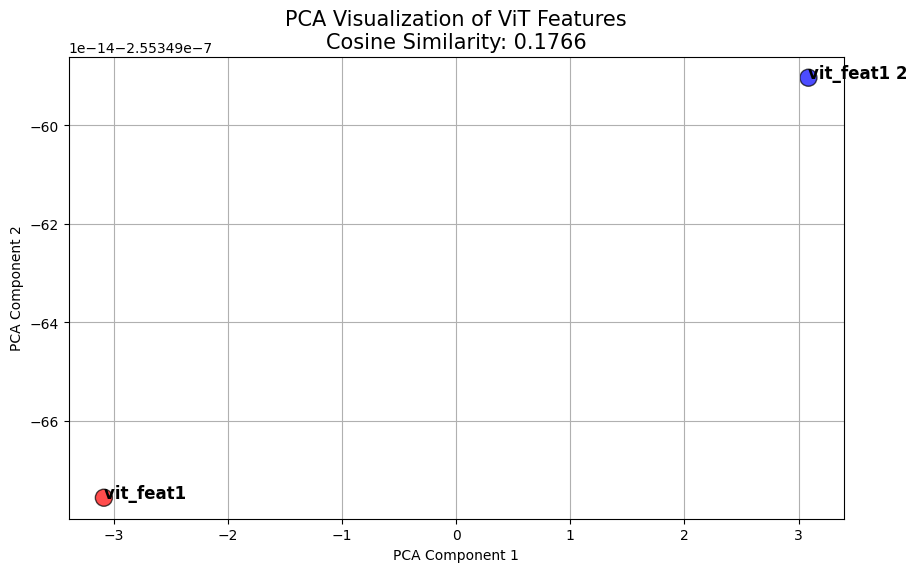

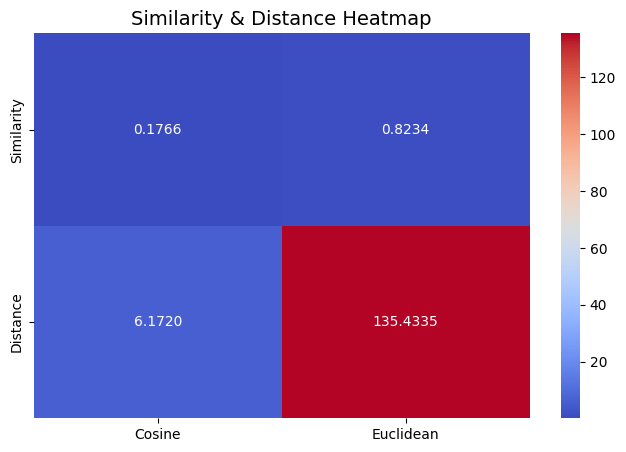

In [ ]:
import torch
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance
import seaborn as sns

# 1. ViT 모델 및 프로세서 로드
vit_model = AutoModel.from_pretrained("google/vit-base-patch16-224-in21k")
vit_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

# 2. 특징 추출 함수 -> CLIP과 동일
def extract_vit_features(img_path):
    image = Image.open(img_path).convert("RGB")
    inputs = vit_processor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = vit_model(**inputs)
    # CLS 토큰 특징 사용 (ViT는 [CLS] 벡터를 전체 이미지 대표로 사용)
    features = outputs.last_hidden_state[:, 0, :]
    return features.squeeze().numpy()

# 3. 이미지 특징 추출
vit_feat1 = extract_vit_features("./ex_data/image_1.jpeg")
vit_feat2 = extract_vit_features("./ex_data/c--88-_jpeg_jpg.rf.e1904e5f6ec8799cbb585551aafbaab1.jpg")


print(vit_feat1, vit_feat2)

# 4. 유사도 계산 (코사인, 유클리드, 맨해튼)
cos_sim = cosine_similarity([vit_feat1], [vit_feat2])[0][0]
euclidean_dist = distance.euclidean(vit_feat1, vit_feat2)
manhattan_dist = distance.cityblock(vit_feat1, vit_feat2)

print(f"✅ 코사인 유사도(Cosine): {cos_sim:.4f}")
print(f"✅ 유클리드 거리(Euclidean): {euclidean_dist:.4f}")
print(f"✅ 맨해튼 거리(Manhattan): {manhattan_dist:.4f}")

# ===================================
# 5. 📊 t-SNE 시각화: 고차원-> 저차원(주로 2차원)으로 축소하여 시각화하는 비선형 차원 축소 기법,저차원 공간에서 데이터 구조를 시각화하는데 유용
# ===================================
features = np.array([vit_feat1, vit_feat2])
tsne = TSNE(n_components=2, random_state=42, perplexity=1)
features_2d = tsne.fit_transform(features)

plt.figure(figsize=(10, 6))
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=['red', 'blue'], s=150, alpha=0.7, edgecolors='k')
for i, txt in enumerate(['vit_feat1 ', 'vit_feat1 2']):
    plt.annotate(txt, (features_2d[i, 0], features_2d[i, 1]), fontsize=12, fontweight='bold')
plt.title(f"t-SNE Visualization of ViT Features\nCosine Similarity: {cos_sim:.4f}", fontsize=15)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(True)
plt.show()

# ===================================
# 6. 📊 PCA 시각화: 고차원->저차원으로 축소하는 선형 차원 축소기법, 데이터의 주요 변동 방향 시각화화
# ===================================
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features)

plt.figure(figsize=(10, 6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=['red', 'blue'], s=150, alpha=0.7, edgecolors='k')
for i, txt in enumerate(['vit_feat1 ', 'vit_feat1 2']):
    plt.annotate(txt, (features_pca[i, 0], features_pca[i, 1]), fontsize=12, fontweight='bold')
plt.title(f"PCA Visualization of ViT Features\nCosine Similarity: {cos_sim:.4f}", fontsize=15)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()

# ===================================
# 7. 🔥 유사도 히트맵 (Cosine, Euclidean, Manhattan):행,열로 구성된 격자 형태의 그래프, 각 셀의 색상은 유사도 or 거리를 나타냄 데이터 포인트 간의 관계를 직관적으로 파악하는데 유용
# ===================================
similarity_matrix = np.array([
    [cos_sim, 1 - cos_sim],
    [euclidean_dist, manhattan_dist]
])

plt.figure(figsize=(8, 5))
sns.heatmap(similarity_matrix, annot=True, fmt='.4f', cmap='coolwarm',
            xticklabels=['Cosine', 'Euclidean'], yticklabels=['Similarity', 'Distance'])
plt.title("Similarity & Distance Heatmap", fontsize=14)
plt.show()
